In [157]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [29]:
emicron_m = pd.read_csv("D:/jupyter/dane/datos_crudos/emicron_moviles.csv")
emicron_22 = pd.read_csv("D:/jupyter/dane/datos_crudos/emicron_22.csv")

In [30]:
emicron_m = emicron_m.rename(columns = lambda x: x.lower())
emicron_22 = emicron_22.rename(columns = lambda x: x.lower())

In [31]:
emicron_m22 = emicron[emicron['ola'] == 2022]
emicron_m22 = emicron_m22.drop(columns = 'ola')
emicron_m22.columns
emicron_22.columns

Index(['directorio', 'secuencia_p', 'secuencia_encuesta', 'cod_depto', 'area',
       'clase_te', 'p35', 'p241', 'mes_ref', 'p3031',
       ...
       'p3014', 'p1573_1', 'p1573_2', 'p1573_3', 'p1573_4', 'p1573_5',
       'p1573_6', 'p1574', 'p1771', 'ola'],
      dtype='object', length=194)

In [32]:
emicron_m = pd.merge(emicron_m22, emicron_22[['id', 'grupos12']], on = 'id')
emicron_m.columns

Index(['id', 'ventas_mes_anterior', 'pottot', 'remuneracion_total', 'cyg',
       'cod_depto', 'cpam', 'grupos4', 'anos_espacio', 'grupos12'],
      dtype='object')

In [39]:
# Definición labels
dic_depto = {5:"Antioquia",8:"Atlántico", 11:"Bogotá, D. C.",13:"Bolívar",15:"Boyacá",17:"Caldas", 18:"Caquetá",
             19:"Cauca", 20:"Cesar", 23:"Córdoba",25:"Cundinamarca", 27:"Chocó", 41:"Huila", 44:"La Guajira", 47:"Magdalena",
             50:"Meta", 52:"Nariño", 54:"Norte De Santander", 63:"Quindío", 66:"Risaralda", 68:"Santander", 70:"Sucre", 73:"Tolima",
             76:"Valle Del Cauca", 88:"San Andrés"}

dic_sector = {2:"Industria", 3:"Comercio", 4:"Servicios"}

dic_rut = {1:"Sí", 0:"No"}

dic_g12 = {3:"Industria",
           4:"Construcción",
           5:"Comercio",
           6:"Transporte y almacenamiento",
           7:"Alojamiento/servicios de comida",
           8:"Información y comunicaciones",
           9:"Actividades inmobiliarias",
           10:"Educación",
           11:"Actividades de salud humana",
           12:"Actividades artiísticas",
}

# Sector económico

In [112]:
crosstab_proporcion = pd.crosstab(index = emicron_22['cod_depto'], columns = emicron_m['grupos4'], normalize = "index")
crosstab_proporcion = crosstab_proporcion[[3, 4, 2]]

crosstab_proporcion = crosstab_proporcion.sort_values(by = 3, ascending = False)

crosstab_proporcion.rename(columns = dic_sector, inplace = True)
crosstab_proporcion.rename(index = dic_depto, inplace = True)
crosstab_proporcion

grupos4,Comercio,Servicios,Industria
cod_depto,,,
Norte De Santander,0.660000,0.300000,0.040000
Santander,0.586207,0.413793,0.000000
Cundinamarca,0.578947,0.394737,0.026316
Cauca,0.527778,0.472222,0.000000
Huila,0.525641,0.423077,0.051282
Caldas,0.522523,0.427928,0.049550
Bolívar,0.509383,0.428954,0.061662
Nariño,0.496403,0.496403,0.007194
Boyacá,0.494382,0.460674,0.044944


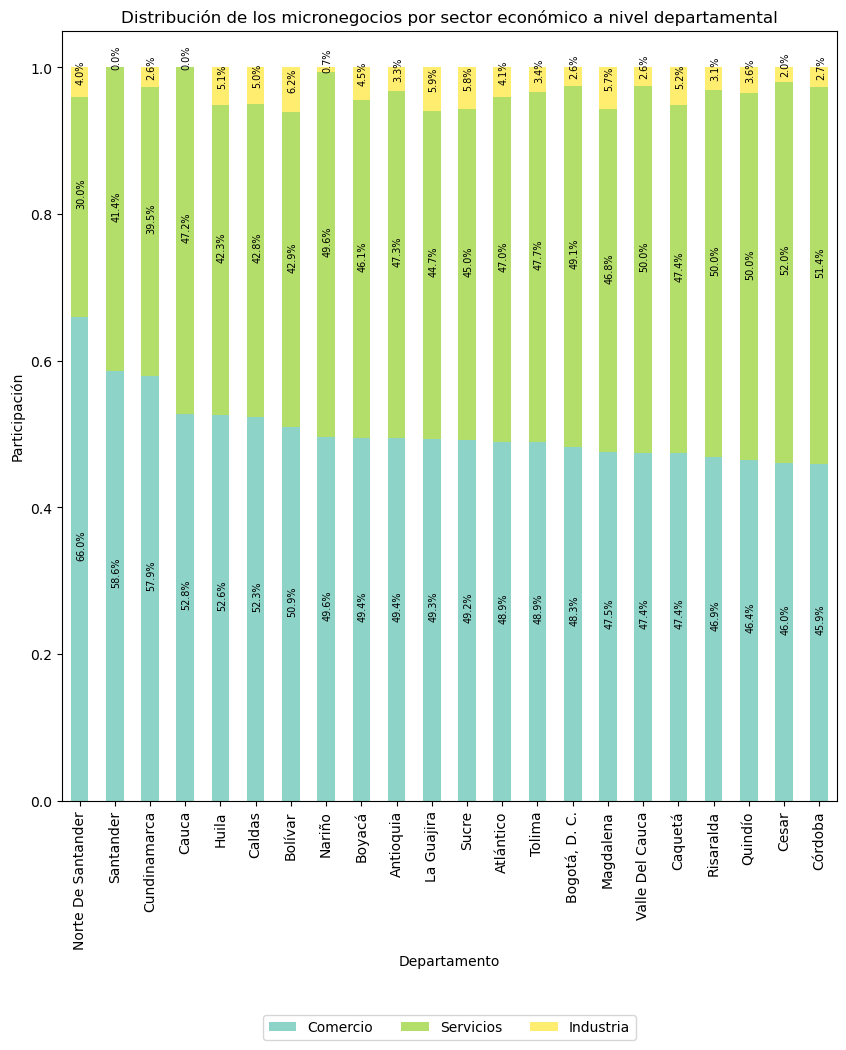

In [122]:
crosstab_proporcion.plot.bar(stacked = True, 
                            colormap = "Set3",
                            figsize = (10, 10))


for n, x in enumerate([*crosstab_proporcion.index.values]):
    for (proportion, y_loc) in zip(crosstab_proporcion.loc[x],
                                   crosstab_proporcion.loc[x].cumsum()):
                
        plt.text(x = n - 0.1,
                 y = (y_loc - proportion) + (proportion / 2),
                 s = f'{np.round(proportion * 100, 1)}%', 
                 color = "black",
                 fontsize = 7,
                 rotation = 'vertical')
                 #fontweight="bold")

plt.xlabel("Departamento")
plt.ylabel("Participación")
plt.title("Distribución de los micronegocios por sector económico a nivel departamental")
        
# Put a legend below current axis
plt.legend(loc ='lower center', bbox_to_anchor = (0.5, -0.32),
          fancybox = True, shadow = False, ncol = 5)

plt.show()

In [105]:
y_loc

0.9221888709305011

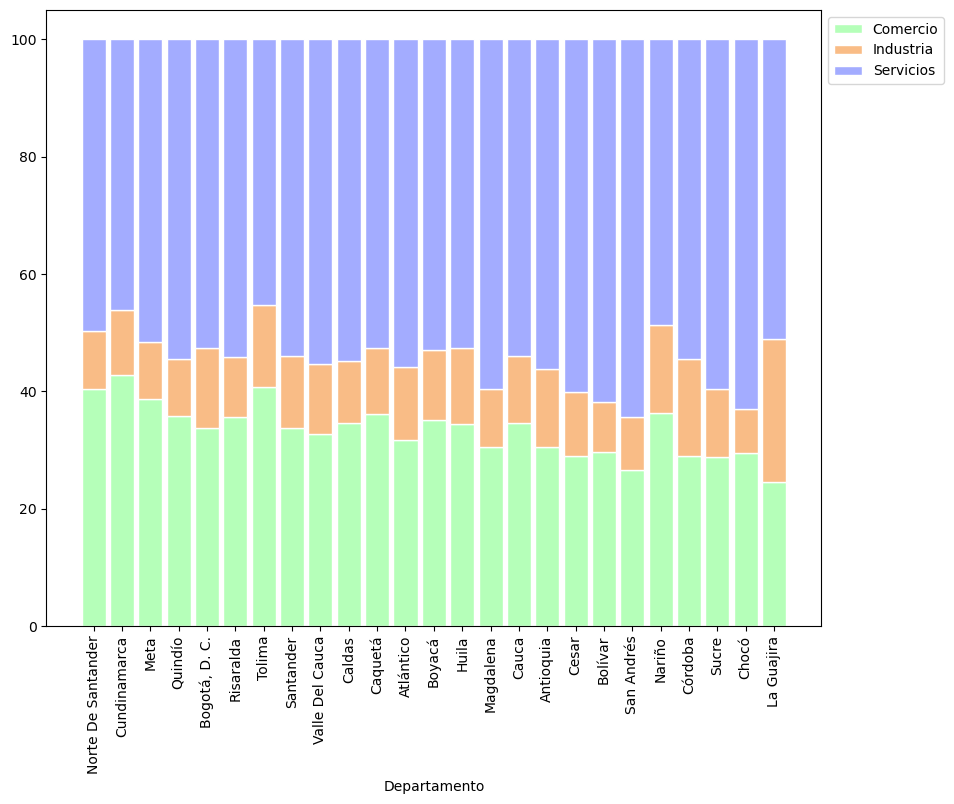

In [83]:
# From raw value to percentage
x = crosstab_proporcion.index
total = [i + j + k for i, j, k in zip(crosstab_proporcion['Comercio'], crosstab_proporcion['Industria'], crosstab_proporcion['Servicios'])]
comercio = [i / j * 100 for i, j in zip(crosstab_proporcion['Comercio'], totals)]
industria = [i / j * 100 for i, j in zip(crosstab_proporcion['Industria'], totals)]
servicios = [i / j * 100 for i, j in zip(crosstab_proporcion['Servicios'], totals)]
 
# plot
barWidth = 0.85
nombres_dpto = crosstab_proporcion.index

fig = plt.figure(figsize = [10,8])

# Create green Bars
plt.bar(x, comercio, color='#b5ffb9', edgecolor='white', width = barWidth, label = 'Comercio')
# Create orange Bars
plt.bar(x, industria, bottom = comercio, color ='#f9bc86', edgecolor = 'white', width=barWidth, label = 'Industria')
# Create blue Bars
plt.bar(x, servicios, bottom = [i+j for i,j in zip(comercio, industria)], color = '#a3acff', edgecolor ='white', width = barWidth,label = 'Servicios')
 
# Custom x axis
plt.xticks(x, nombres_dpto, rotation = 90)
plt.xlabel("Departamento")
plt.legend(loc = 'upper left', bbox_to_anchor = (1,1), ncol = 1)

# Show graphic
plt.show()

# Ingresos

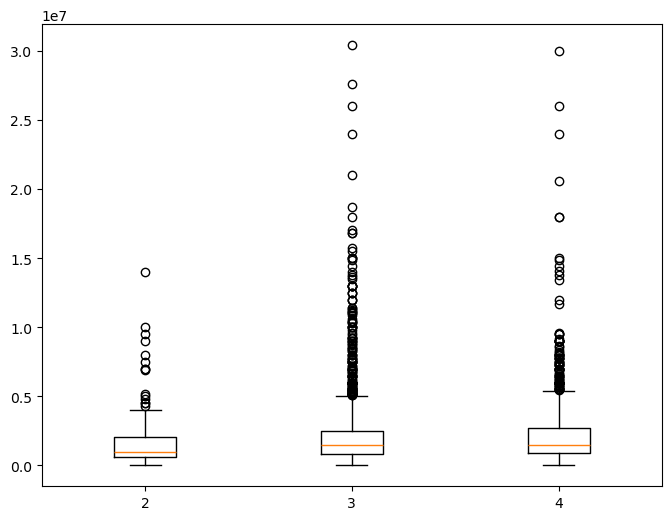

In [134]:
grupos = emicron_m22.groupby('grupos4')['ventas_mes_anterior']

# Init a figure and axes
fig, ax = plt.subplots(figsize = (8,6))

# Create the plot
ax.boxplot(x = [group.values for name, group in grupos], labels = grupos.groups.keys())

# Display it
plt.show()

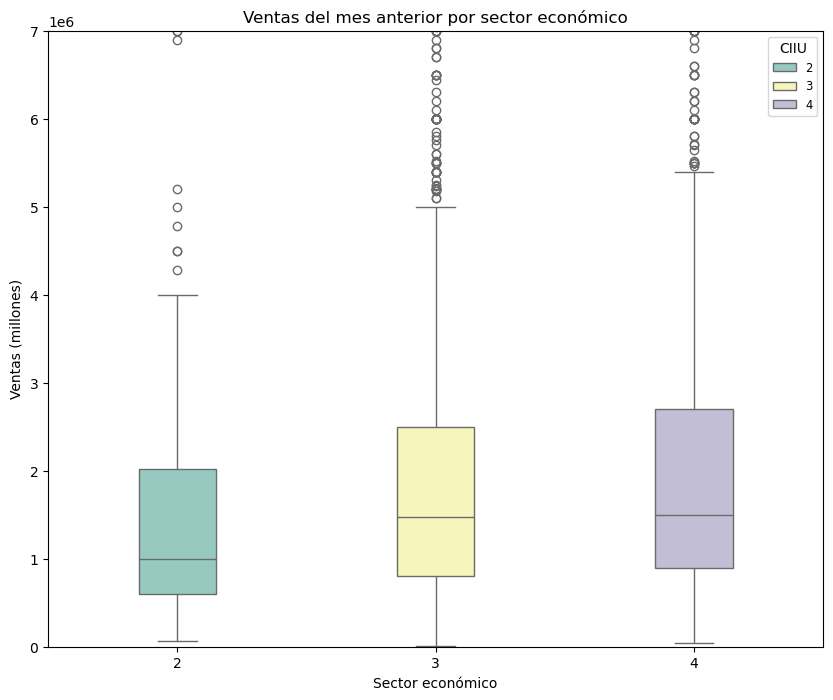

In [173]:
fig = plt.figure(figsize = [10, 8])
sns.boxplot(x = 'grupos4', y = 'ventas_mes_anterior', data = emicron_m22, palette = "Set3", hue = 'grupos4', width = 0.3)
plt.title("Ventas del mes anterior por sector económico")
plt.ylabel("Ventas (millones)")
plt.xlabel("Sector económico")
# q1, q3 = emicron_m22['ventas_mes_anterior'].describe()[[4,6]]
# plt.ylim((0, q3 + 1.5*(q3-q1)))
plt.ylim(0, 7000000)
plt.legend(loc = 'upper right', title = 'CIIU', fontsize = 'small')
#plt.show()


In [153]:
emicron_m22['ventas_mes_anterior'].describe()[[4,6]]

C:\Users\cegut\AppData\Local\Temp\ipykernel_21340\4252254883.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



25%     800000.0
75%    2550000.0
Name: ventas_mes_anterior, dtype: float64